# Region Growing Method
implemented 6 neighbors and 26 neighbors.

In [2]:
"""
Implementation
6 neighbors
"""
import numpy as np

def get_nbhd_6(pt, checked, dims):
    # object : 6 neighbor hood
    nbhd = []
    # check pt values whether in range or not
    # check under region focused points (x-1, y-1, z-1)
    if not checked[pt[0]-1, pt[1], pt[2]]:
        nbhd.append((pt[0]-1, pt[1], pt[2]))
    if not checked[pt[0], pt[1]-1, pt[2]]:
        nbhd.append((pt[0], pt[1]-1, pt[2]))
    if not checked[pt[0], pt[1], pt[2]-1]:
        nbhd.append((pt[0], pt[1], pt[2]-1))

    # check upper region focused points (x+1, y+1, z+1)
    if not checked[pt[0]+1, pt[1], pt[2]]:
        nbhd.append((pt[0]+1, pt[1], pt[2]))
    if not checked[pt[0], pt[1]+1, pt[2]]:
        nbhd.append((pt[0], pt[1]+1, pt[2]))
    if (pt[2] < dims[2]-1) and not checked[pt[0], pt[1], pt[2]+1]:
        nbhd.append((pt[0], pt[1], pt[2]+1))

    return nbhd

def grow6(img, seed, t):
    """
    img  : ndarray, ndim=3
    seed : tuple, len=3
    t    : int, range of average value
     The image neighborhood radius for the inclusion criteria
    """
    # segmented and checked volume
    seg = np.zeros(img.shape, dtype=np.bool)
    checked = np.zeros_like(seg)
    
    seg[seed] = True
    checked[seed] = True
    needs_check = get_nbhd_6(seed, checked, img.shape) # get neighborhood
    while len(needs_check) > 0:
        # processing points one by one
        pt = needs_check.pop()
        
        # A point can be put in needs_check even if the point was already marked checked.
        if checked[pt]:
            continue
        checked[pt] = True
        
        # Handle 6 borders
        imin = max(pt[0]-t, 0)
        imax = min(pt[0]+t, img.shape[0]-1)
        jmin = max(pt[1]-t, 0)
        jmax = min(pt[1]+t, img.shape[1]-1)
        kmin = max(pt[2]-t, 0)
        kmax = min(pt[2]+t, img.shape[2]-1)

        # adapt the conditions below for paper?
        if img[pt] >= img[imin:imax+1, jmin:jmax+1, kmin:kmax+1].mean():
            # Include the voxel in the segmentation and
            # add its neighbors to be checked.
            seg[pt] = True
#             print (pt)
            needs_check += get_nbhd_6(pt, checked, img.shape)

    return seg
            

In [1]:
"""
Implementation
26 neighbors
"""
import numpy as np
import itertools


def get_nbhd_26(pt, checked, dims):
    # object : 26 neighbor hood
    nbhd = []
    # check pt values whether in range or not
    # search range
    r = [-1,0,1]
    moves = list(itertools.product(r,r,r))
    moves.remove((0,0,0))
    
    for mv in moves:
        if min((pt[0]+mv[0], pt[1]+mv[1], pt[2]+mv[2])) < 0:
            continue
        if (pt[0]+mv[0] > dims[0]-1) or (pt[1]+mv[1] > dims[1]-1) or (pt[2]+mv[2] > dims[2]-1):
            continue
        if not checked[pt[0]+mv[0], pt[1]+mv[1], pt[2]+mv[2]]:
            nbhd.append((pt[0]+mv[0], pt[1]+mv[1], pt[2]+mv[2]))

    return nbhd

def grow26(img, seed, t):
    """
    img  : ndarray, ndim=3
    seed : tuple, len=3
    t    : int, range of average value
     The image neighborhood radius for the inclusion criteria
    """
    # segmented and checked volume
    seg = np.zeros(img.shape, dtype=np.bool)
    checked = np.zeros_like(seg)
    
    seg[seed] = True
    checked[seed] = True
    needs_check = get_nbhd_26(seed, checked, img.shape) # get neighborhood
    
    while len(needs_check) > 0:
        # processing points one by one
        pt = needs_check.pop()
        
        # A point can be put in needs_check even if the point was already marked checked.
        if checked[pt]:
            continue
        checked[pt] = True
        
        imin = max(pt[0]-t, 0)
        imax = min(pt[0]+t, img.shape[0]-1)
        jmin = max(pt[1]-t, 0)
        jmax = min(pt[1]+t, img.shape[1]-1)
        kmin = max(pt[2]-t, 0)
        kmax = min(pt[2]+t, img.shape[2]-1)

        # adapt each conditions below
        if img[pt] >= img[imin:imax+1, jmin:jmax+1, kmin:kmax+1].mean():
            # Include the voxel in the segmentation and
            # add its neighbors to be checked.
            seg[pt] = True
            needs_check += get_nbhd_26(pt, checked, img.shape)

    return seg
            

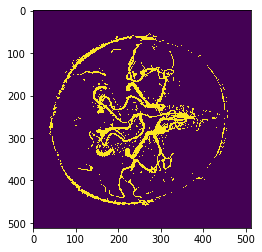

In [12]:
%matplotlib inline
"""
MIP Image
Region Growing Execute
"""
import time
import nibabel as nib
import os,re
from matplotlib import pyplot as plt
data_path = os.getcwd() # assign data path

# File name with file numbering
files_with_num = [(file,int(re.search(r"[0-9]+",file).group(0))) for file in os.listdir(data_path) if re.match(r"[0-9]*.nii",file)]
filenames = [f[0] for f in sorted(files_with_num, key=lambda x:x[1])]
data = nib.load(data_path+filenames[0]).get_data().astype(int)

# Convert slice values to only each max value (provisional)
data_max = []
for d in data.transpose()[:,]:
    sl = np.zeros_like(d)
    sl[d >= d.max()/2] = True
    data_max.append(sl)
data_max = np.asarray(data_max).transpose()

seed = np.unravel_index(np.argmax(data_max), data_max.shape)
plt.imshow(np.amax(data_max,axis=2))
plt.show()

In [13]:
start = time.time()
seg = grow26(data_max, seed, 5)
stop = time.time()
print("Elapsed time: %.3f seconds." % (stop - start))

Elapsed time: 0.245 seconds.


In [14]:
%%time
from mayavi import mlab
src = mlab.pipeline.scalar_field(seg.astype(np.float))
mlab.pipeline.iso_surface(src, contours=[0.7], opacity=0.5)
mlab.show()

CPU times: user 4.35 s, sys: 587 ms, total: 4.93 s
Wall time: 10.8 s
